In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split, KFold
import warnings
from numpy import savetxt
from numpy import loadtxt
warnings.filterwarnings("ignore")
import pickle

/home/arslan/anaconda3/envs/solar/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
from sklearn.metrics import r2_score
import optuna
from sklearn.ensemble import BaggingRegressor,AdaBoostRegressor,GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
from sklearn.svm import SVR
from catboost import CatBoostRegressor, Pool
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
import math
import matplotlib.pyplot as plt
import shap

2023-05-25 16:51:56.002244: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-25 16:51:56.166095: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-9.0/lib64
2023-05-25 16:51:56.166116: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-05-25 16:51:56.197637: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-05-25 16:51:56.9053

In [3]:
train = loadtxt('Data_Set/efficiencyTrain.csv', delimiter=',')
label = loadtxt('Data_Set/efficiencylabel.csv', delimiter=',')

In [4]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="2"

In [5]:
def showResults(model, modelName,X_test,y_test):
    y_ped = model.predict(X_test)
    MSE = mean_squared_error(y_test, y_ped)
    RMSE = math.sqrt(MSE)
    resultsDict = {'R2: ':r2_score(y_test,model.predict(X_test)), 'MSE: ':MSE, 'MAE: ':mean_absolute_error(y_test,y_ped),
           'RMSE: ':RMSE}

    # open file for writing
    name = "Results/" + modelName + "Efficency.txt"
    
    # save the model to disk
    filename = "Saved_Models/" + modelName + "Efficency.sav"
    pickle.dump(model, open(filename, 'wb'))
    
    f = open(name,"w")
    # write file
    f.write( str(resultsDict) )
    # close file
    f.close()
    print(resultsDict)

In [6]:
def drawPlots(model,modelName,X_test,y_test):
    y_ped = model.predict(X_test)
    plt.scatter(y_ped,y_test,s=10,marker ="s",c=y_test,cmap=plt.get_cmap('plasma'))
    plt.plot(y_test,y_test)
    plt.xlabel('Experimental Efficiency \n a')
    plt.ylabel('Predicated Efficiency')
    plt.title(modelName + ' Efficiency')
    plt.grid(False)
    name = "Visualization/" + modelName + "Efficiency.png"
    plt.savefig(name, dpi=400,transparent=True,bbox_inches = "tight")
    plt.show()

In [7]:
def trainingWithKfolds():
    
    params = {'iterations': 21243, 'learning_rate': 0.05975976829789766, 'depth': 10,
              'random_seed': 332, 'metric_period': 470, 'od_wait': 143}
    k_fold=KFold(n_splits=6)
    scores = []
    true_val = []
    pred_val = []
    fig = plt.figure()
    i = 1
    for tr, tst in k_fold.split(train,label):


        model_regressor = CatBoostRegressor(**params)

        X_train, X_test, y_train, y_test = train[tr],train[tst],label[tr],label[tst]
        model_regressor.fit(X_train, y_train, 
          eval_set=(X_test, y_test),  
          use_best_model=True,  
          plot= False   
         );
        
        y_ped = model_regressor.predict(X_test)
        true_val.append(y_test)
        pred_val.append(y_ped)
        MSE = mean_squared_error(y_test, y_ped)
        RMSE = math.sqrt(MSE)
        score = r2_score(y_test,model_regressor.predict(X_test))
        scores.append(score)
        
#         plt.scatter(y_ped,y_test,s=10,marker ="s",c=y_test,cmap=plt.get_cmap('plasma'),
#                     label='Fold %d (R2 = %0.2f)' % (i,score))
        
        plt.scatter(y_ped, y_test, lw=2, alpha=0.5,cmap=plt.get_cmap('plasma'),
                label='Fold %d (R2 = %0.2f)' % (i,score))
        
        i = i+1
    print("R2 Average",np.average(scores))
    plt.plot([min(y_ped),max(y_test)], [min(y_ped),max(y_test)], 
         linestyle='--', lw=2, color='black')
    plt.xlabel('Experimental Efficiency')
    plt.ylabel('Predicated Efficiency')
    plt.title('CatBoostRegressor 6-Fold Validation')
    plt.legend()
    plt.grid(False)
    plt.savefig('5FoldsR2Efficiency.png', dpi=400,transparent=True)
    plt.show()

0:	learn: 0.0442159	test: 0.0474888	best: 0.0474888 (0)	total: 50.2ms	remaining: 17m 46s
Stopped by overfitting detector  (143 iterations wait)

bestTest = 0.0411657858
bestIteration = 82

Shrink model to first 83 iterations.
0:	learn: 0.0460187	test: 0.0387358	best: 0.0387358 (0)	total: 6.34ms	remaining: 2m 14s


Stopped by overfitting detector  (143 iterations wait)

bestTest = 0.03109446373
bestIteration = 301

Shrink model to first 302 iterations.
0:	learn: 0.0447216	test: 0.0452360	best: 0.0452360 (0)	total: 1.57ms	remaining: 33.5s


470:	learn: 0.0113423	test: 0.0361286	best: 0.0361024 (466)	total: 1.07s	remaining: 47.3s
940:	learn: 0.0058355	test: 0.0352716	best: 0.0352413 (908)	total: 2.25s	remaining: 48.5s
Stopped by overfitting detector  (143 iterations wait)

bestTest = 0.03510654718
bestIteration = 1242

Shrink model to first 1243 iterations.
0:	learn: 0.0435980	test: 0.0510010	best: 0.0510010 (0)	total: 2.33ms	remaining: 49.6s


Stopped by overfitting detector  (143 iterations wait)

bestTest = 0.03924919891
bestIteration = 293

Shrink model to first 294 iterations.
0:	learn: 0.0454224	test: 0.0422102	best: 0.0422102 (0)	total: 1.72ms	remaining: 36.6s


470:	learn: 0.0122438	test: 0.0339028	best: 0.0338299 (414)	total: 1.03s	remaining: 45.4s
Stopped by overfitting detector  (143 iterations wait)

bestTest = 0.03382992349
bestIteration = 414

Shrink model to first 415 iterations.
0:	learn: 0.0447103	test: 0.0452367	best: 0.0452367 (0)	total: 2.23ms	remaining: 47.5s


Stopped by overfitting detector  (143 iterations wait)

bestTest = 0.03703490535
bestIteration = 322

Shrink model to first 323 iterations.
R2 Average 0.34731808755354915


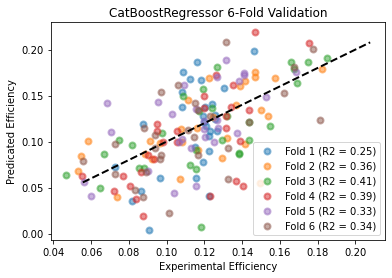

In [8]:
trainingWithKfolds()